In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path

# Change to repo root directory (parent of 'analysis' folder)
# In Jupyter, we can use the notebook's directory or go up from current directory
current_dir = Path.cwd()
if current_dir.name == 'analysis':
    # If we're in the analysis folder, go up one level
    repo_root = current_dir.parent
elif 'analysis' in current_dir.parts:
    # If analysis is in the path, find repo root
    idx = current_dir.parts.index('analysis')
    repo_root = Path(*current_dir.parts[:idx])
else:
    # Otherwise, assume we're already at repo root or need to navigate
    repo_root = Path('/Users/svngo/Documents/GitHub/Dicty-Cell-Aggregation-Analysis')

os.chdir(repo_root)
print(f"Working directory: {os.getcwd()}")

Working directory: /Users/svngo/Documents/GitHub/Dicty-Cell-Aggregation-Analysis


In [16]:
# Read CSV, skipping the extra header rows (TrackMate exports have multiple header rows)
# Row 0: actual column names (keep as header)
# Row 1-3: descriptive headers we want to skip
edges_path = 'results/trial_3/20260206_224003_subset_edges.csv'
spots_path = 'results/trial_3/20260206_224003_subset_spots.csv'
edges = pd.read_csv(edges_path, header=0, skiprows=[1, 2, 3])  # Keep row 0 as header, skip rows 1-3
spots = pd.read_csv(spots_path, header=0, skiprows=[1, 2, 3])

print(f"DataFrame shape: {edges.shape}")
print(f"\nColumns: {edges.columns.tolist()}")
edges.head()

DataFrame shape: (10719, 13)

Columns: ['LABEL', 'TRACK_ID', 'SPOT_SOURCE_ID', 'SPOT_TARGET_ID', 'LINK_COST', 'DIRECTIONAL_CHANGE_RATE', 'SPEED', 'DISPLACEMENT', 'EDGE_TIME', 'EDGE_X_LOCATION', 'EDGE_Y_LOCATION', 'EDGE_Z_LOCATION', 'MANUAL_EDGE_COLOR']


,LABEL,TRACK_ID,SPOT_SOURCE_ID,SPOT_TARGET_ID,LINK_COST,DIRECTIONAL_CHANGE_RATE,SPEED,DISPLACEMENT,EDGE_TIME,EDGE_X_LOCATION,EDGE_Y_LOCATION,EDGE_Z_LOCATION,MANUAL_EDGE_COLOR
0,ID554826 → ID554635,0,554826,554635,10.479494,NaN,2.472511,2.472511,0.5,190.847919,249.699022,0.0,NaN
1,ID555081 → ID554981,0,555081,554981,28.002000,0.622373,1.774840,1.774840,2.5,191.006070,249.642027,0.0,NaN
2,ID554981 → ID554772,0,554981,554772,0.042748,2.447633,1.060959,1.060959,3.5,191.593560,249.646044,0.0,NaN
3,ID556111 → ID556342,0,556111,556342,2.338630,2.840419,0.952779,0.952779,8.5,191.788058,250.393479,0.0,NaN
4,ID554635 → ID555081,0,554635,555081,9.016805,2.855178,0.461510,0.461510,1.5,190.211231,248.905988,0.0,NaN


In [17]:
spots.head()

,LABEL,ID,TRACK_ID,QUALITY,POSITION_X,POSITION_Y,POSITION_Z,POSITION_T,FRAME,RADIUS,...,ELLIPSE_Y0,ELLIPSE_MAJOR,ELLIPSE_MINOR,ELLIPSE_THETA,ELLIPSE_ASPECTRATIO,AREA,PERIMETER,CIRCULARITY,SOLIDITY,SHAPE_INDEX
0,ID555081,555081,0,256.0,190.285113,249.124595,0.0,2.0,2,9.053441,...,0.312021,10.501882,8.393338,1.116109,1.251216,257.5,69.509440,0.669730,0.894097,4.331668
1,ID554826,554826,0,321.0,191.558489,250.710663,0.0,0.0,0,10.124020,...,0.327645,13.686488,7.861003,0.975135,1.741061,322.0,86.968336,0.534987,0.824584,4.846556
2,ID555274,555274,0,261.0,191.494220,250.146757,0.0,5.0,5,9.088532,...,0.143661,11.585449,7.554834,0.967845,1.533515,259.5,84.043829,0.461674,0.803406,5.217196
3,ID557258,557258,0,298.0,193.309764,250.383838,0.0,16.0,16,9.723067,...,0.411175,12.673752,8.003717,0.935217,1.583483,297.0,85.337007,0.512497,0.838983,4.951755
4,ID554635,554635,0,261.0,190.137349,248.687380,0.0,1.0,1,9.123488,...,-0.032827,10.472385,8.168952,1.146933,1.281974,261.5,71.671677,0.639715,0.874582,4.432122


In [18]:
# merge edges with spots twice

# Select only the columns we need from spots (position and time)
spot_cols_needed = ['ID', 'POSITION_X', 'POSITION_Y', 'POSITION_T']

# First merge: get source spot positions
merged = edges.merge(
    spots[spot_cols_needed], 
    left_on='SPOT_SOURCE_ID', 
    right_on='ID', 
    how='inner'
)
# Rename the position/time columns to have '_source' suffix
merged = merged.rename(columns={
    'POSITION_X': 'POSITION_X_source',
    'POSITION_Y': 'POSITION_Y_source', 
    'POSITION_T': 'POSITION_T_source'
})
# Drop the 'ID' column from spots (we don't need it anymore)
merged = merged.drop(columns=['ID'])

# Second merge: get target spot positions
merged = merged.merge(
    spots[spot_cols_needed], 
    left_on='SPOT_TARGET_ID', 
    right_on='ID', 
    how='inner'
)
# Rename the position/time columns to have '_target' suffix
merged = merged.rename(columns={
    'POSITION_X': 'POSITION_X_target',
    'POSITION_Y': 'POSITION_Y_target',
    'POSITION_T': 'POSITION_T_target'
})
# Drop the 'ID' column again
merged = merged.drop(columns=['ID'])

In [19]:
merged.head()

,LABEL,TRACK_ID,SPOT_SOURCE_ID,SPOT_TARGET_ID,LINK_COST,DIRECTIONAL_CHANGE_RATE,SPEED,DISPLACEMENT,EDGE_TIME,EDGE_X_LOCATION,EDGE_Y_LOCATION,EDGE_Z_LOCATION,MANUAL_EDGE_COLOR,POSITION_X_source,POSITION_Y_source,POSITION_T_source,POSITION_X_target,POSITION_Y_target,POSITION_T_target
0,ID554826 → ID554635,0,554826,554635,10.479494,NaN,2.472511,2.472511,0.5,190.847919,249.699022,0.0,NaN,191.558489,250.710663,0.0,190.137349,248.687380,1.0
1,ID555081 → ID554981,0,555081,554981,28.002000,0.622373,1.774840,1.774840,2.5,191.006070,249.642027,0.0,NaN,190.285113,249.124595,2.0,191.727027,250.159459,3.0
2,ID554981 → ID554772,0,554981,554772,0.042748,2.447633,1.060959,1.060959,3.5,191.593560,249.646044,0.0,NaN,191.727027,250.159459,3.0,191.460094,249.132629,4.0
3,ID556111 → ID556342,0,556111,556342,2.338630,2.840419,0.952779,0.952779,8.5,191.788058,250.393479,0.0,NaN,191.419975,250.091052,8.0,192.156140,250.695906,9.0
4,ID554635 → ID555081,0,554635,555081,9.016805,2.855178,0.461510,0.461510,1.5,190.211231,248.905988,0.0,NaN,190.137349,248.687380,1.0,190.285113,249.124595,2.0


## Note: Image Coordinate System (ImageJ) NEEDS ATTENTION
ImageJ/TrackMate uses image coordinates, not mathematical coordinates:
- Origin (0, 0) is at the top-left corner of the image
- X-axis: increases to the right (positive = right, negative = left)
- Y-axis: increases downward (positive = down, negative = up)

In [20]:
delta_T = merged['POSITION_T_target'] - merged['POSITION_T_source']
# Fix: Need parentheses around the position difference before dividing by delta_T
merged['V_x'] = (merged['POSITION_X_target'] - merged['POSITION_X_source']) / delta_T
merged['V_y'] = (merged['POSITION_Y_target'] - merged['POSITION_Y_source']) / delta_T

In [21]:
merged.head()

,LABEL,TRACK_ID,SPOT_SOURCE_ID,SPOT_TARGET_ID,LINK_COST,DIRECTIONAL_CHANGE_RATE,SPEED,DISPLACEMENT,EDGE_TIME,EDGE_X_LOCATION,...,EDGE_Z_LOCATION,MANUAL_EDGE_COLOR,POSITION_X_source,POSITION_Y_source,POSITION_T_source,POSITION_X_target,POSITION_Y_target,POSITION_T_target,V_x,V_y
0,ID554826 → ID554635,0,554826,554635,10.479494,NaN,2.472511,2.472511,0.5,190.847919,...,0.0,NaN,191.558489,250.710663,0.0,190.137349,248.687380,1.0,-1.421140,-2.023282
1,ID555081 → ID554981,0,555081,554981,28.002000,0.622373,1.774840,1.774840,2.5,191.006070,...,0.0,NaN,190.285113,249.124595,2.0,191.727027,250.159459,3.0,1.441914,1.034864
2,ID554981 → ID554772,0,554981,554772,0.042748,2.447633,1.060959,1.060959,3.5,191.593560,...,0.0,NaN,191.727027,250.159459,3.0,191.460094,249.132629,4.0,-0.266933,-1.026830
3,ID556111 → ID556342,0,556111,556342,2.338630,2.840419,0.952779,0.952779,8.5,191.788058,...,0.0,NaN,191.419975,250.091052,8.0,192.156140,250.695906,9.0,0.736166,0.604854
4,ID554635 → ID555081,0,554635,555081,9.016805,2.855178,0.461510,0.461510,1.5,190.211231,...,0.0,NaN,190.137349,248.687380,1.0,190.285113,249.124595,2.0,0.147765,0.437215


In [22]:
# validate VELOCITY == SPEED 
merged['VELOCITY'] = np.sqrt(merged['V_x'] ** 2 + merged['V_y'] ** 2)
print('Magnitude of velocity and speed are equal: ' + str(all(np.isclose(np.abs(merged['VELOCITY']), merged['SPEED'], rtol=1e-05))))

Magnitude of velocity and speed are equal: True


In [23]:
# unit vector direction components of the wave
wave_x_unit = -0.875
wave_y_unit = -0.485

In [24]:
# Normalize velocity to unit vector
V_x = merged['V_x']
V_y = merged['V_y']

velocity_magnitude = np.sqrt(V_x**2 + V_y**2)
V_x_unit = V_x / velocity_magnitude
V_y_unit = V_y / velocity_magnitude

# Dot product with wave unit vector
merged['cosine'] = V_x_unit * wave_x_unit + V_y_unit * wave_y_unit

# Sort by closest to 1 (most aligned)
sorted_by_alignment = merged.sort_values('cosine', ascending=False)
sorted_by_alignment['cosine']

4236    1.000425
7254    1.000425
8531    1.000424
9877    1.000424
2880    1.000424
          ...   
1406   -1.000421
4632   -1.000423
5110   -1.000423
4445   -1.000425
3764   -1.000425
Name: cosine, Length: 10719, dtype: float64

In [25]:
# Parallel component (along wave direction)
merged['V_parallel'] = V_x * wave_x_unit + V_y * wave_y_unit

# Orthogonal component (projection/perpendicular to wave)
merged['V_orthogonal'] = V_x * (-wave_y_unit) + V_y * wave_x_unit  # rotate wave vector 90°
sorted_by_orthogonality = merged.sort_values('V_orthogonal', ascending=False) # note: NOT unit
sorted_by_orthogonality['V_orthogonal']

1989    16.024197
1965     9.352328
6080     7.709038
7359     7.240613
5150     6.456006
          ...    
7971    -9.590523
2743   -10.183697
2812   -10.875487
2436   -14.265996
3785   -18.683141
Name: V_orthogonal, Length: 10719, dtype: float64

In [26]:
# Extract V_parallel and V_orthogonal as Series
V_parallel = merged['V_parallel']
V_orthogonal = merged['V_orthogonal']

print(f"V_parallel: {len(V_parallel)} values")
print(f"V_orthogonal: {len(V_orthogonal)} values")
print(f"\nV_parallel stats:")
print(V_parallel.describe())
print(f"\nV_orthogonal stats:")
print(V_orthogonal.describe())

V_parallel: 10719 values
V_orthogonal: 10719 values

V_parallel stats:
count    10719.000000
mean        -0.039178
std          0.870389
min        -11.927205
25%         -0.280696
50%         -0.030296
75%          0.216587
max         16.621273
Name: V_parallel, dtype: float64

V_orthogonal stats:
count    10719.000000
mean         0.058576
std          0.908275
min        -18.683141
25%         -0.216676
50%          0.052969
75%          0.340607
max         16.024197
Name: V_orthogonal, dtype: float64


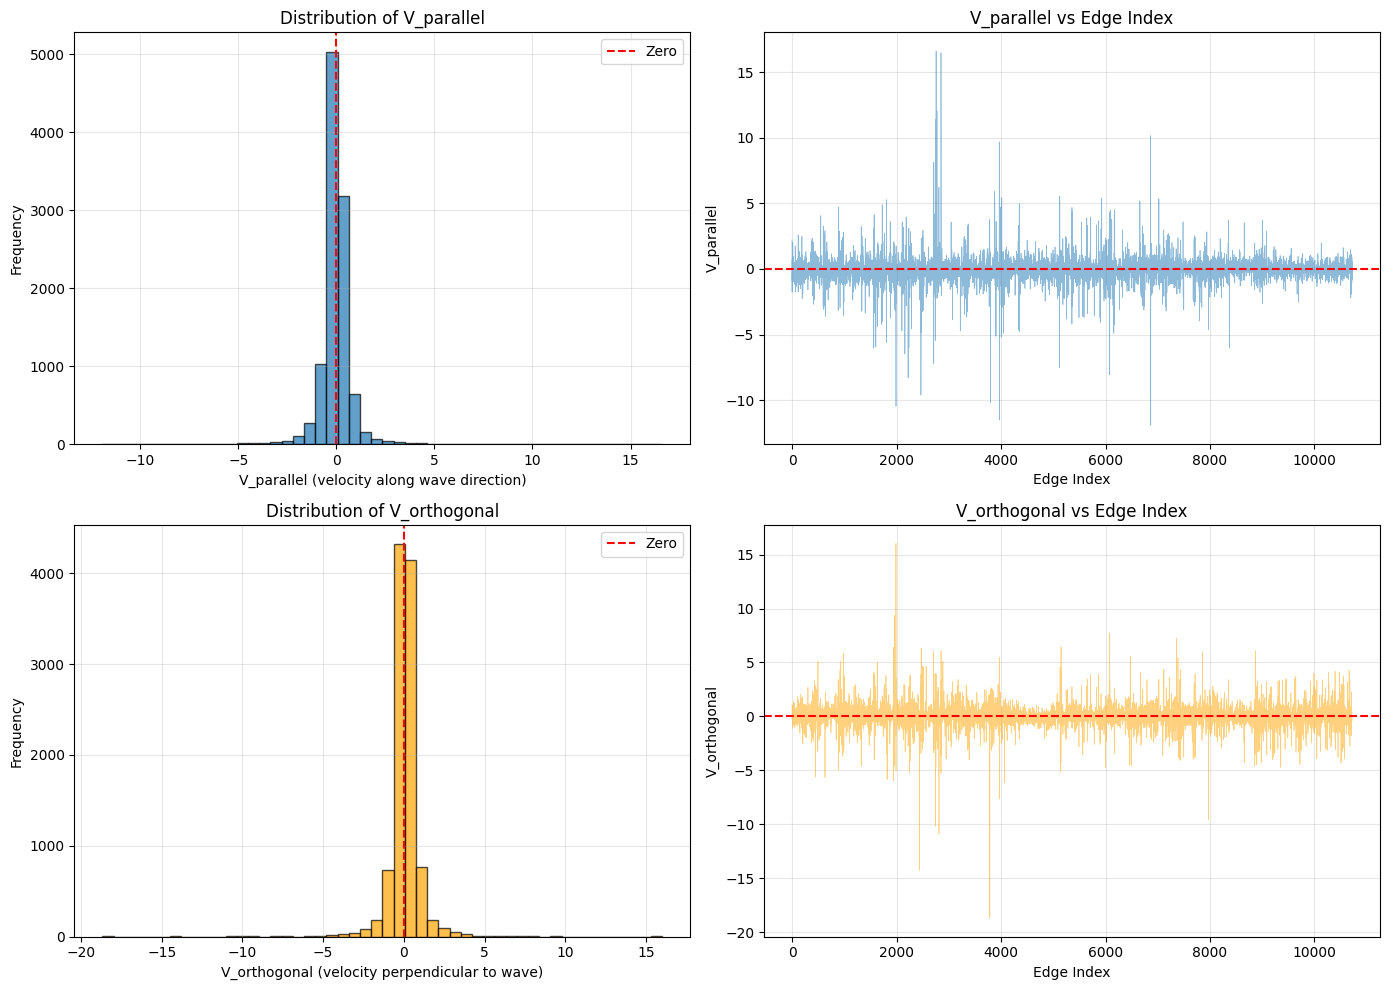

In [30]:
# Create plots for V_parallel and V_orthogonal
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# V_parallel plots
axes[0, 0].hist(V_parallel, bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('V_parallel (velocity along wave direction)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of V_parallel')
axes[0, 0].axvline(0, color='red', linestyle='--', label='Zero')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(V_parallel.index, V_parallel.values, alpha=0.5, linewidth=0.5)
axes[0, 1].set_xlabel('Edge Index')
axes[0, 1].set_ylabel('V_parallel')
axes[0, 1].set_title('V_parallel vs Edge Index')
axes[0, 1].axhline(0, color='red', linestyle='--')
axes[0, 1].grid(True, alpha=0.3)

# V_orthogonal plots
axes[1, 0].hist(V_orthogonal, bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1, 0].set_xlabel('V_orthogonal (velocity perpendicular to wave)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Distribution of V_orthogonal')
axes[1, 0].axvline(0, color='red', linestyle='--', label='Zero')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(V_orthogonal.index, V_orthogonal.values, alpha=0.5, linewidth=0.5, color='orange')
axes[1, 1].set_xlabel('Edge Index')
axes[1, 1].set_ylabel('V_orthogonal')
axes[1, 1].set_title('V_orthogonal vs Edge Index')
axes[1, 1].axhline(0, color='red', linestyle='--')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

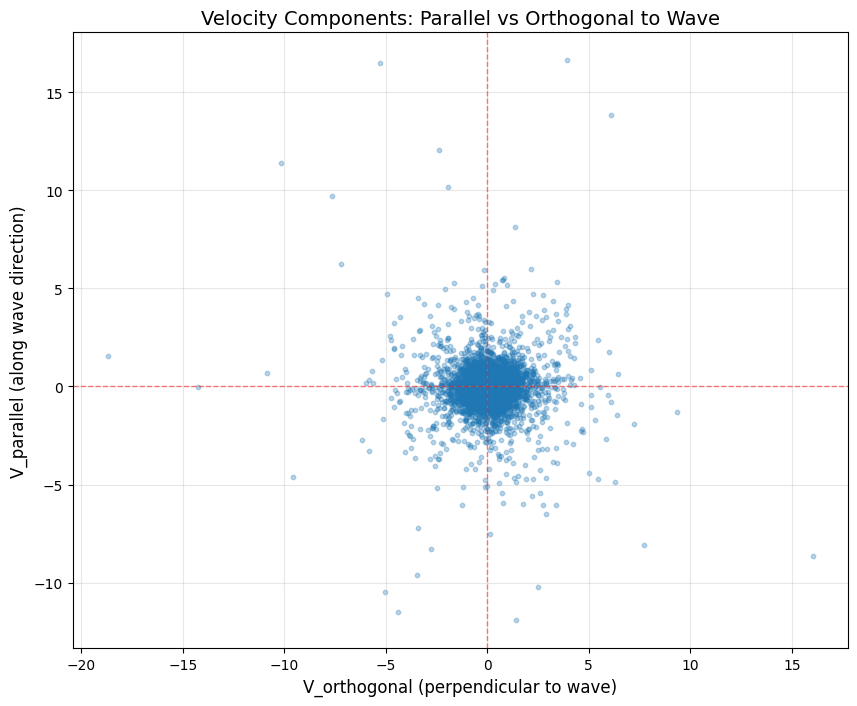

Quadrant Analysis:
Q1 (V_orthogonal > 0, V_parallel > 0): 2809 edges
Q2 (V_orthogonal < 0, V_parallel > 0): 2138 edges
Q3 (V_orthogonal < 0, V_parallel < 0): 2638 edges
Q4 (V_orthogonal > 0, V_parallel < 0): 3134 edges


In [31]:
# Scatter plot: V_parallel vs V_orthogonal
plt.figure(figsize=(10, 8))
plt.scatter(V_orthogonal, V_parallel, alpha=0.3, s=10)
plt.xlabel('V_orthogonal (perpendicular to wave)', fontsize=12)
plt.ylabel('V_parallel (along wave direction)', fontsize=12)
plt.title('Velocity Components: Parallel vs Orthogonal to Wave', fontsize=14)
plt.axhline(0, color='red', linestyle='--', linewidth=1, alpha=0.5)
plt.axvline(0, color='red', linestyle='--', linewidth=1, alpha=0.5)
plt.grid(True, alpha=0.3)
plt.show()

# Print quadrant analysis
print("Quadrant Analysis:")
print(f"Q1 (V_orthogonal > 0, V_parallel > 0): {((V_orthogonal > 0) & (V_parallel > 0)).sum()} edges")
print(f"Q2 (V_orthogonal < 0, V_parallel > 0): {((V_orthogonal < 0) & (V_parallel > 0)).sum()} edges")
print(f"Q3 (V_orthogonal < 0, V_parallel < 0): {((V_orthogonal < 0) & (V_parallel < 0)).sum()} edges")
print(f"Q4 (V_orthogonal > 0, V_parallel < 0): {((V_orthogonal > 0) & (V_parallel < 0)).sum()} edges")

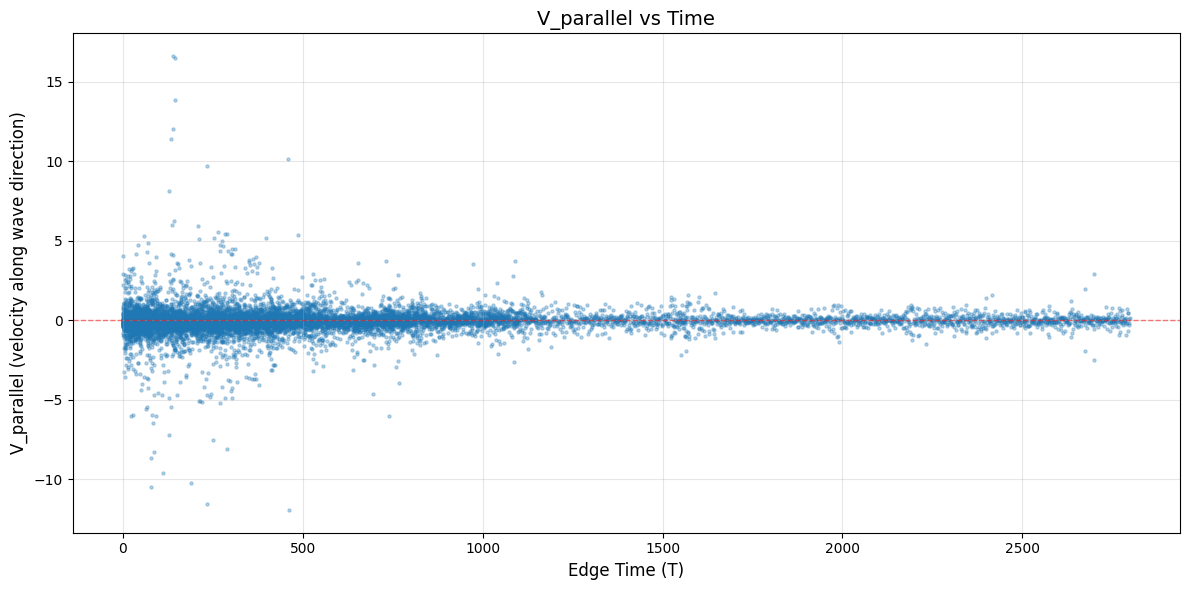

In [33]:
# Use EDGE_TIME if available, otherwise use average of source and target times
if 'EDGE_TIME' in merged.columns:
    T = merged['EDGE_TIME']
    time_label = 'Edge Time (T)'
else:
    # Use midpoint time between source and target
    T = (merged['POSITION_T_source'] + merged['POSITION_T_target']) / 2
    time_label = 'Time (T) - Midpoint'

# Plot V_parallel vs Time
plt.figure(figsize=(12, 6))
plt.scatter(T, V_parallel.values, alpha=0.3, s=5)
plt.xlabel(time_label, fontsize=12)
plt.ylabel('V_parallel (velocity along wave direction)', fontsize=12)
plt.title('V_parallel vs Time', fontsize=14)
plt.axhline(0, color='red', linestyle='--', linewidth=1, alpha=0.5)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [34]:
# Diagnostic: Understand wave direction and V_parallel meaning
print("Wave Direction Vector:")
print(f"  wave_x_unit = {wave_x_unit}")
print(f"  wave_y_unit = {wave_y_unit}")
print(f"  Magnitude = {np.sqrt(wave_x_unit**2 + wave_y_unit**2):.3f} (should be ~1.0 for unit vector)")
print(f"\nWave direction points toward: ({wave_x_unit:.3f}, {wave_y_unit:.3f})")
print(f"In image coordinates: X={wave_x_unit:.3f} (negative = left, positive = right)")
print(f"                      Y={wave_y_unit:.3f} (negative = up, positive = down)")
print(f"\nV_parallel interpretation:")
print(f"  Positive V_parallel = cell moving in SAME direction as wave")
print(f"  Negative V_parallel = cell moving OPPOSITE direction to wave")
print(f"\nIf wave propagates bottom-right but vector is ({wave_x_unit}, {wave_y_unit}):")
print(f"  - Vector points left-up, which is opposite to bottom-right")
print(f"  - This might mean the vector represents wave origin direction, not propagation")

Wave Direction Vector:
  wave_x_unit = -0.875
  wave_y_unit = -0.485
  Magnitude = 1.000 (should be ~1.0 for unit vector)

Wave direction points toward: (-0.875, -0.485)
In image coordinates: X=-0.875 (negative = left, positive = right)
                      Y=-0.485 (negative = up, positive = down)

V_parallel interpretation:
  Positive V_parallel = cell moving in SAME direction as wave
  Negative V_parallel = cell moving OPPOSITE direction to wave

If wave propagates bottom-right but vector is (-0.875, -0.485):
  - Vector points left-up, which is opposite to bottom-right
  - This might mean the vector represents wave origin direction, not propagation


In [35]:
# Find the spike: edges with large positive V_parallel
spike_threshold = 10  # Adjust based on your plot
spike_edges = merged[V_parallel > spike_threshold].copy()

print(f"Number of edges with V_parallel > {spike_threshold}: {len(spike_edges)}")
if len(spike_edges) > 0:
    print(f"\nTrack IDs involved in spike:")
    track_ids = spike_edges['TRACK_ID'].unique()
    print(f"  Unique tracks: {track_ids}")
    print(f"\nTrack ID frequencies:")
    print(spike_edges['TRACK_ID'].value_counts().head(10))
    
    # Check if it's one long track
    if len(track_ids) == 1:
        print(f"\n✓ The spike corresponds to a SINGLE track: {track_ids[0]}")
        print(f"  This is likely your 'long purple track'!")
    else:
        print(f"\nThe spike involves {len(track_ids)} different tracks")
    
    # Show time range of spike
    if 'EDGE_TIME' in spike_edges.columns:
        print(f"\nTime range of spike: {spike_edges['EDGE_TIME'].min():.1f} to {spike_edges['EDGE_TIME'].max():.1f}")
    else:
        T_spike = (spike_edges['POSITION_T_source'] + spike_edges['POSITION_T_target']) / 2
        print(f"\nTime range of spike: {T_spike.min():.1f} to {T_spike.max():.1f}")
    
    # Show average velocity direction for spike
    avg_Vx_spike = spike_edges['V_x'].mean()
    avg_Vy_spike = spike_edges['V_y'].mean()
    print(f"\nAverage velocity direction during spike: ({avg_Vx_spike:.3f}, {avg_Vy_spike:.3f})")
    print(f"  This means: X={avg_Vx_spike:.3f} (negative=left, positive=right)")
    print(f"              Y={avg_Vy_spike:.3f} (negative=up, positive=down)")
else:
    print(f"No edges found with V_parallel > {spike_threshold}")
    print("Try lowering the threshold or check the plot for the actual spike value")

Number of edges with V_parallel > 10: 6

Track IDs involved in spike:
  Unique tracks: [163 170 174 178 179 297]

Track ID frequencies:
TRACK_ID
163    1
170    1
174    1
178    1
179    1
297    1
Name: count, dtype: int64

The spike involves 6 different tracks

Time range of spike: 134.5 to 458.5

Average velocity direction during spike: (-12.524, -5.092)
  This means: X=-12.524 (negative=left, positive=right)
              Y=-5.092 (negative=up, positive=down)
